In [1]:
import datetime

import matplotlib.pyplot as plt
import pandas as pd
from boiler.constants import column_names
from boiler.data_processing.beetween_filter_algorithm import FullClosedTimestampFilterAlgorithm
from dateutil.tz import gettz

import config

In [2]:
# "engelsa_35.pickle" 6
# "engelsa_37.pickle" 6
# "gaydara_1.pickle" 3
# "gaydara_22.pickle" 2
# "gaydara_26.pickle" 4
# "gaydara_28.pickle" 5
# "gaydara_30.pickle" 5
# "gaydara_32.pickle" 5
# "kuibysheva_10.pickle" 3
# "kuibysheva_14.pickle" 3
# "kuibysheva_16.pickle" 3
# "kuibysheva_8.pickle" 3

In [3]:
start_datetime = datetime.datetime(2018, 12, 1, 0, 0, 0, tzinfo=gettz(config.DEFAULT_TIMEZONE))
end_datetime = datetime.datetime(2019, 4, 1, 0, 0, 0, tzinfo=gettz(config.DEFAULT_TIMEZONE))
boiler_round_step = 0.1

dataset_name = "engelsa_37.pickle"
lag = 6

start_datetime = pd.Timestamp(start_datetime)
end_datetime = pd.Timestamp(end_datetime)

filter_algorithm = FullClosedTimestampFilterAlgorithm()

boiler_df = pd.read_pickle(config.BOILER_PREPROCESSED_HEATING_CIRCUIT_DATASET_PATH)
boiler_df = filter_algorithm.filter_df_by_min_max_timestamp(boiler_df, start_datetime, end_datetime)
boiler_forward_temp = boiler_df[column_names.FORWARD_TEMP].to_numpy()

dataset_path = f"{config.APARTMENT_HOUSE_PREPROCESSED_DATASETS_HEATING_CIRCUIT_DIR}\\{dataset_name}"
home_df = pd.read_pickle(dataset_path)
home_df = filter_algorithm.filter_df_by_min_max_timestamp(home_df, start_datetime, end_datetime)
home_forward_temp = home_df[column_names.FORWARD_TEMP].to_numpy()

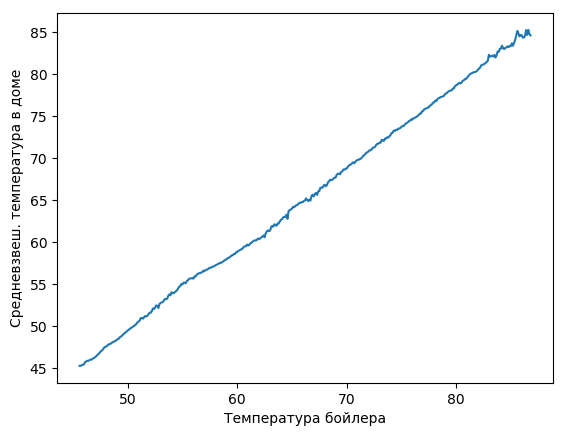

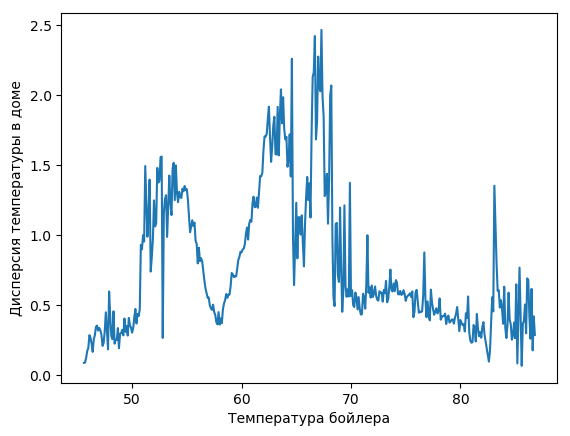

Min/Max std 0.06364241560102617, 2.4646149904893173


In [4]:
home_column = "HOME"
boiler_column = "BOILER"
boiler_rounded_column = "BOILER_ROUNDED"
mean_group_value_column = "MEAN_GROUP_TEMP"
std_group_value_column = "STD_GROUP"

correlation_df = pd.DataFrame({
    boiler_column: boiler_forward_temp[:-lag],
    home_column: home_forward_temp[lag:]
})

correlation_df[boiler_rounded_column] = correlation_df[boiler_column].apply(
    lambda x: x // boiler_round_step * boiler_round_step
)
mean_series = correlation_df.groupby(boiler_rounded_column)[home_column].mean()
correlation_df[mean_group_value_column] = correlation_df[boiler_rounded_column].apply(
    lambda x: mean_series[x]
)
std_series = correlation_df.groupby(boiler_rounded_column)[home_column].std()
correlation_df[std_group_value_column] = correlation_df[boiler_rounded_column].apply(
    lambda x: std_series[x]
)

correlation_df = correlation_df.sort_values(boiler_rounded_column)
correlation_df = correlation_df[correlation_df[std_group_value_column].notnull()]
boiler_temp = correlation_df[boiler_rounded_column].to_numpy()
mean_temp = correlation_df[mean_group_value_column].to_numpy()
std_temp = correlation_df[std_group_value_column].to_numpy()

plt.plot(boiler_temp, mean_temp)
plt.xlabel("Температура бойлера")
plt.ylabel("Средневзвеш. температура в доме")
plt.show()

plt.plot(boiler_temp, std_temp)
plt.xlabel("Температура бойлера")
plt.ylabel("Дисперсия температуры в доме")
plt.show()

print(f"Min/Max std {std_temp.min()}, {std_temp.max()}")

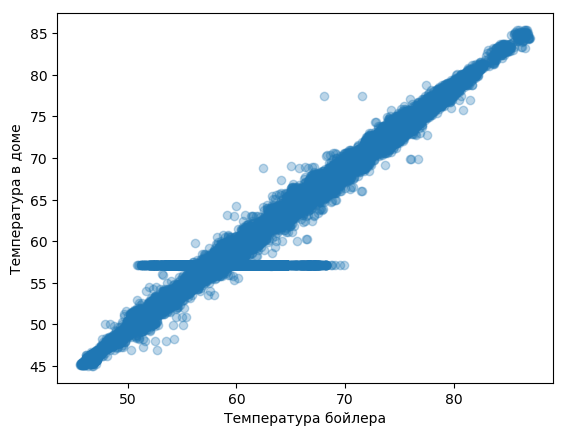

In [5]:
moved_boiler_temp = boiler_forward_temp[:-lag],
moved_home_temp = home_forward_temp[lag:]
plt.scatter(moved_boiler_temp, moved_home_temp, alpha=0.3)
plt.xlabel("Температура бойлера")
plt.ylabel("Температура в доме")
plt.show()